In [1]:
# Cell 1: Install dependencies
# Uncomment and run the following command if dependencies are not already installed.
# %pip install scikit-learn scikit-image SimpleITK nibabel nilearn albumentations seaborn pandas numpy matplotlib tqdm pydicom scipy
%pip install umap-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Cell 2: Import statements and environment setup
import torch

def configure_gpu():
    """
    Configures GPU settings:
    - Detects CUDA device
    - Enables CUDNN benchmarking for improved performance on NVIDIA 4070Ti
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # Enable CUDNN benchmark for optimized convolution algorithm selection
        torch.backends.cudnn.benchmark = True
        print(f"Using GPU: {torch.cuda.get_device_name(device)}")
    else:
        raise EnvironmentError("CUDA-compatible GPU not found. Please check your GPU configuration.")

def print_gpu_memory_stats():
    """
    Prints current GPU memory usage for monitoring.
    """
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 2)
        reserved = torch.cuda.memory_reserved() / (1024 ** 2)
        print(f"GPU Memory Allocated: {allocated:.2f} MB")
        print(f"GPU Memory Reserved: {reserved:.2f} MB")
    else:
        print("CUDA not available.")

# Configure GPU on startup
configure_gpu()
print_gpu_memory_stats()

import warnings
warnings.filterwarnings('ignore')

Using GPU: NVIDIA GeForce RTX 4070 Ti
GPU Memory Allocated: 0.00 MB
GPU Memory Reserved: 0.00 MB


In [3]:
# Cell 3: GPU Setup and Memory Management
import os
import logging
import warnings
import pandas as pd

# Configure logging for quality assurance (logs will be written to data_ingestion.log)
logging.basicConfig(level=logging.INFO, filename="data_ingestion.log", filemode="w",
                    format="%(asctime)s - %(levelname)s - %(message)s")

def collect_files(base_dir):
    """
    Recursively collects DICOM files only from the expected folders:
    - PPMI_Images_PD: Label "PD"
    - PPMI_Images_SWEDD: Label "SWEDD"
    - PPMI_Images_Cont: Label "Control"
    
    Excludes any file containing "br_raw" in its path and logs all skipped folders.
    
    :param base_dir: Base directory containing the Images folder.
    :return: (included_files, excluded_files)
             included_files: list of tuples (full_path, label)
             excluded_files: list of file paths that were excluded.
    """
    included_files = []
    excluded_files = []
    
    # Define the expected folders and corresponding labels
    expected_folders = {
        "PPMI_Images_PD": "PD",
        "PPMI_Images_SWEDD": "SWEDD",
        "PPMI_Images_Cont": "Control"
    }
    
    # Iterate over immediate subdirectories in base_dir
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path) and folder in expected_folders:
            logging.info(f"Processing folder: {folder_path}")
            # Recursively traverse the expected folder
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".dcm"):
                        full_path = os.path.join(root, file)
                        # Exclude any file with "br_raw" in its full path
                        if "br_raw" in full_path:
                            excluded_files.append(full_path)
                            logging.info(f"Excluding raw file: {full_path}")
                        else:
                            included_files.append((full_path, expected_folders[folder]))
        else:
            logging.info(f"Skipping folder: {folder_path}")
    
    return included_files, excluded_files

def generate_dataframe(included_files):
    """
    Creates a DataFrame from the list of validated file paths.
    
    :param included_files: List of tuples (file_path, label)
    :return: DataFrame with columns 'file_path' and 'label'
    """
    df = pd.DataFrame(included_files, columns=["file_path", "label"])
    return df

def save_qa_report(total_files, included_count, excluded_count, output_path="data_ingestion_QA_report.csv"):
    """
    Generates and saves a QA report of the file collection process.
    
    :param total_files: Total number of DICOM files encountered.
    :param included_count: Count of files included after filtering.
    :param excluded_count: Count of files excluded.
    :param output_path: File path for the QA report CSV.
    """
    exclusion_ratio = excluded_count / total_files if total_files > 0 else 0
    qa_report = {
        "total_files": total_files,
        "included_files": included_count,
        "excluded_files": excluded_count,
        "exclusion_ratio": exclusion_ratio,
    }
    qa_df = pd.DataFrame([qa_report])
    qa_df.to_csv(output_path, index=False)
    logging.info("QA report saved to %s", output_path)
    
    if exclusion_ratio > 0.5:
        warnings.warn(f"High proportion of raw files excluded: {exclusion_ratio:.2%}")


In [4]:
# Cell 4: Data Ingestion Pipeline
import pydicom
import numpy as np

def load_dicom(file_path):
    """
    Loads and processes a DICOM file:
    - Reads the file using pydicom.
    - Converts the pixel array to float32.
    - Applies RescaleSlope and RescaleIntercept if available.
    
    :param file_path: Path to the DICOM file.
    :return: Tuple (processed_pixel_array, dicom_metadata)
    """
    try:
        ds = pydicom.dcmread(file_path)
    except Exception as e:
        raise IOError(f"Error reading DICOM file {file_path}: {e}")
    
    # Extract pixel array and convert to float32
    pixel_array = ds.pixel_array.astype(np.float32)
    
    # Apply rescaling if attributes are present
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        slope = ds.RescaleSlope
        intercept = ds.RescaleIntercept
        pixel_array = pixel_array * slope + intercept
    
    return pixel_array, ds

In [5]:
# Cell 5: Execute Data Ingestion Pipeline
# Define the base directory containing the "Images" folder (adjust if necessary)
base_dir = "Images"

# Collect files from only the expected subdirectories
included_files, excluded_files = collect_files(base_dir)

# Create a DataFrame for the validated file paths and their labels
df = generate_dataframe(included_files)

# Final validation: Ensure that no "br_raw" files are included
if df["file_path"].str.contains("br_raw").any():
    raise ValueError("Validation failed: 'br_raw' files detected in the final dataset!")

# Save the validated file paths to CSV for reproducibility
df.to_csv("validated_file_paths.csv", index=False)
print("Validated file paths saved to validated_file_paths.csv")

# Generate and save the QA report
total_files = len(included_files) + len(excluded_files)
save_qa_report(total_files, len(included_files), len(excluded_files))
print("QA report generated and saved as data_ingestion_QA_report.csv")

Validated file paths saved to validated_file_paths.csv
QA report generated and saved as data_ingestion_QA_report.csv


Loading file for group PD: Images\PPMI_Images_PD\3203\Reconstructed_DaTSCAN\2012-12-12_12_53_45.0\I418896\PPMI_3203_NM_Reconstructed_DaTSCAN_Br_20140404125303483_1_S197896_I418896.dcm
Loading file for group SWEDD: Images\PPMI_Images_SWEDD\3582\Reconstructed_DaTSCAN\2014-06-03_08_18_03.0\I449246\PPMI_3582_NM_Reconstructed_DaTSCAN_Br_20141022165612888_1_S225362_I449246.dcm
Loading file for group Control: Images\PPMI_Images_Cont\129031\Reconstructed_DaTSCAN\2022-03-22_14_19_30.0\I1574630\PPMI_129031_NM_Reconstructed_DaTSCAN_Br_20220428101326408_1_S1128608_I1574630.dcm


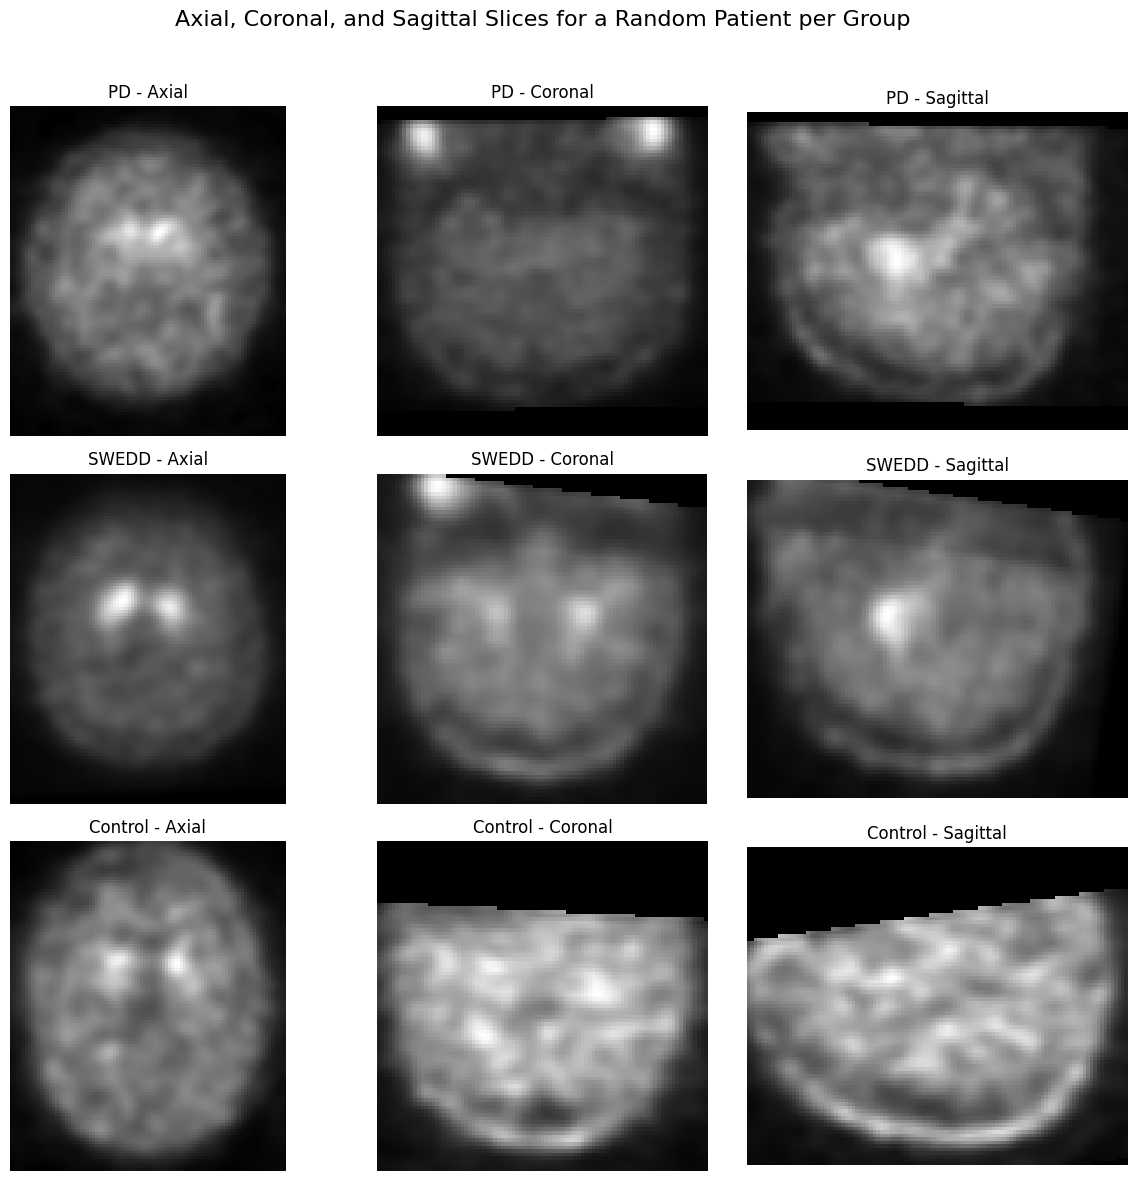

In [6]:
# Cell 6: Visualize One Axial, Coronal, and Sagittal Slice for a Random Patient per Group

import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np

# Read the validated file paths CSV generated earlier
df = pd.read_csv("validated_file_paths.csv")

# Function to extract the three orthogonal slices from a 3D volume
def extract_slices(volume):
    """
    Given a 3D volume, returns one axial, one coronal, and one sagittal slice.
    Assumes volume shape is (depth, height, width).
    """
    d, h, w = volume.shape
    axial = volume[d // 2, :, :]         # Axial: slice along depth
    coronal = volume[:, h // 2, :]        # Coronal: slice along height
    sagittal = volume[:, :, w // 2]       # Sagittal: slice along width
    return axial, coronal, sagittal

# List of groups and their expected labels
groups = {"PD": "PD", "SWEDD": "SWEDD", "Control": "Control"}

# Create a figure with one row per group and three columns for the views
fig, axes = plt.subplots(nrows=len(groups), ncols=3, figsize=(12, 4 * len(groups)))
fig.suptitle("Axial, Coronal, and Sagittal Slices for a Random Patient per Group", fontsize=16)

for i, (group_key, group_label) in enumerate(groups.items()):
    # Filter DataFrame for the current group
    group_df = df[df["label"] == group_label]
    if group_df.empty:
        print(f"No data found for group {group_label}")
        continue
    
    # Select a random file from the group
    random_file = group_df.sample(1)["file_path"].values[0]
    print(f"Loading file for group {group_label}: {random_file}")
    
    # Load the DICOM volume using the previously defined load_dicom() function
    volume, _ = load_dicom(random_file)
    
    # Verify the volume is 3D (if not, skip or raise an error)
    if volume.ndim != 3:
        raise ValueError(f"Expected 3D volume, got shape {volume.shape} for file: {random_file}")
    
    axial, coronal, sagittal = extract_slices(volume)
    
    # Plot Axial slice
    ax = axes[i, 0]
    ax.imshow(axial, cmap="gray")
    ax.set_title(f"{group_label} - Axial")
    ax.axis("off")
    
    # Plot Coronal slice
    ax = axes[i, 1]
    ax.imshow(coronal, cmap="gray")
    ax.set_title(f"{group_label} - Coronal")
    ax.axis("off")
    
    # Plot Sagittal slice
    ax = axes[i, 2]
    ax.imshow(sagittal, cmap="gray")
    ax.set_title(f"{group_label} - Sagittal")
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [7]:
# Cell 7: Data Preprocessing – Intensity Normalization & Volume Processing

import numpy as np

def intensity_normalization(volume):
    """
    Normalizes intensity values:
    - Truncates negative values (sets them to 0)
    - Applies min-max scaling to bring values between 0 and 1 per volume.
    
    :param volume: Input 3D volume as a numpy array.
    :return: Normalized volume.
    """
    volume = np.clip(volume, a_min=0, a_max=None)
    vol_min, vol_max = volume.min(), volume.max()
    if vol_max > vol_min:
        volume = (volume - vol_min) / (vol_max - vol_min)
    else:
        volume = volume - vol_min  # volume is constant
    return volume

def resize_volume(volume, target_shape=(128, 128, 128)):
    """
    Resizes the volume to the target shape using zero-padding or center cropping while preserving aspect ratio.
    
    :param volume: Input 3D volume (numpy array) with shape (d, h, w).
    :param target_shape: Desired output shape (d_out, h_out, w_out).
    :return: Resized volume with shape target_shape.
    """
    current_shape = volume.shape
    resized = volume.copy()
    
    # For each dimension, either pad or crop to the target size
    for i in range(3):
        current = resized.shape[i]
        target = target_shape[i]
        if current < target:
            # Calculate padding sizes
            pad_total = target - current
            pad_before = pad_total // 2
            pad_after = pad_total - pad_before
            pad_width = [(0, 0), (0, 0), (0, 0)]
            pad_width[i] = (pad_before, pad_after)
            resized = np.pad(resized, pad_width=pad_width, mode="constant", constant_values=0)
        elif current > target:
            # Center crop
            start = (current - target) // 2
            end = start + target
            if i == 0:
                resized = resized[start:end, :, :]
            elif i == 1:
                resized = resized[:, start:end, :]
            elif i == 2:
                resized = resized[:, :, start:end]
    return resized

# Example usage (for testing on one volume):
volume, _ = load_dicom(random_file)  # random_file selected previously
norm_vol = intensity_normalization(volume)
resized_vol = resize_volume(norm_vol)
print("Original shape:", volume.shape, "Resized shape:", resized_vol.shape)

Original shape: (91, 109, 91) Resized shape: (128, 128, 128)


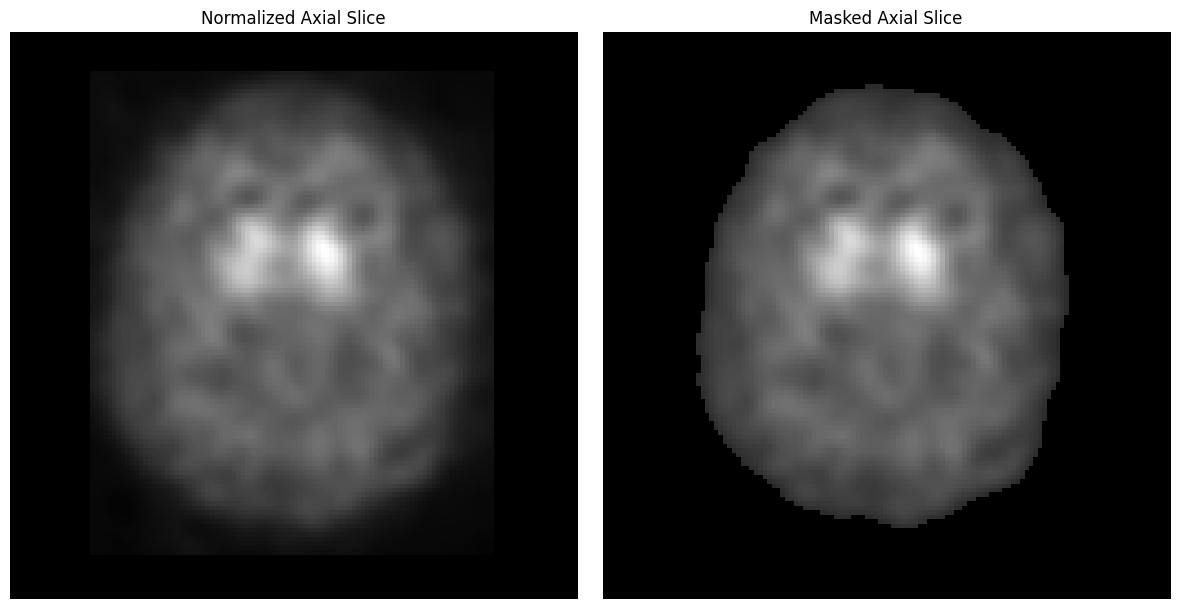

In [8]:
# Cell 8: Data Preprocessing – Brain Masking

import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing, ball

def resize_volume(volume, target_shape=(128, 128, 128)):
    """
    Resizes the volume to the target shape using zero-padding or center cropping.
    
    Args:
        volume: Input 3D volume as numpy array with shape (d, h, w)
        target_shape: Desired output shape as tuple (d_new, h_new, w_new)
        
    Returns:
        Resized volume with shape target_shape
    """
    def get_pad_amounts(current_size, target_size):
        """Helper to calculate padding amounts"""
        if current_size >= target_size:
            return 0, 0
        diff = target_size - current_size
        pad_before = diff // 2
        pad_after = diff - pad_before
        return pad_before, pad_after
    
    current_shape = volume.shape
    resized = volume.copy()
    
    # Calculate padding/cropping for each dimension
    pads = [get_pad_amounts(current_shape[i], target_shape[i]) for i in range(3)]
    
    # Apply padding if needed
    if any(sum(p) > 0 for p in pads):
        resized = np.pad(
            resized,
            pad_width=pads,
            mode="constant",
            constant_values=0
        )
    
    # Apply cropping if needed
    for i in range(3):
        if current_shape[i] > target_shape[i]:
            # Calculate slicing indices
            start = (current_shape[i] - target_shape[i]) // 2
            end = start + target_shape[i]
            # Apply slice
            if i == 0:
                resized = resized[start:end, :, :]
            elif i == 1:
                resized = resized[:, start:end, :]
            else:
                resized = resized[:, :, start:end]
    
    return resized

def process_volume(volume, target_shape=(128, 128, 128)):
    """
    Process a 3D volume by:
    1. Normalizing intensity (truncating negatives and min-max scaling)
    2. Resizing to target_shape
    3. Generating a brain mask via Otsu thresholding and morphological closing
    
    Args:
        volume: Input 3D volume
        target_shape: Desired output shape (depth, height, width)
    
    Returns:
        norm_vol: Normalized and resized volume
        mask: Brain mask
        masked_vol: Masked volume
    """
    # 1. Intensity normalization
    volume = np.clip(volume, a_min=0, a_max=None)
    vmin, vmax = volume.min(), volume.max()
    if vmax > vmin:
        norm_vol = (volume - vmin) / (vmax - vmin)
    else:
        norm_vol = volume - vmin
    
    # 2. Resize the normalized volume
    norm_vol = resize_volume(norm_vol, target_shape=target_shape)
    
    # 3. Compute brain mask
    thresh = threshold_otsu(norm_vol)
    mask = norm_vol > thresh
    mask = binary_closing(mask, footprint=ball(2))
    masked_vol = norm_vol * mask
    
    return norm_vol, mask, masked_vol

# Demonstration: Load one sample DICOM file (using the first file in your validated DataFrame)
sample_file = df.iloc[0]["file_path"]
original_volume, _ = load_dicom(sample_file)

# Process the volume with our new function
norm_vol, mask, masked_vol = process_volume(original_volume, target_shape=(128,128,128))

# Extract an axial (middle) slice from both the normalized volume and the masked volume
axial_norm = norm_vol[norm_vol.shape[0]//2, :, :]
axial_masked = masked_vol[masked_vol.shape[0]//2, :, :]

# Plot side-by-side for comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(axial_norm, cmap="gray")
axes[0].set_title("Normalized Axial Slice")
axes[0].axis("off")

axes[1].imshow(axial_masked, cmap="gray")
axes[1].set_title("Masked Axial Slice")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [9]:
# Cell 9: Dataset Implementation with Shape Validation
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import gc
import numpy as np
import os
import psutil
from sklearn.model_selection import train_test_split

class DaTScanDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        self._calculate_dataset_statistics()

    def _calculate_dataset_statistics(self):
        """Calculate dataset statistics with optimized processing"""
        chunk_size = 50  # Increased chunk size
        stats_list = []
        
        for i in tqdm(range(0, len(self.df), chunk_size), desc="Computing dataset stats"):
            chunk = self.df.iloc[i:min(i+chunk_size, len(self.df))]
            chunk_stats = []
            
            # Process each file in the chunk
            for _, row in chunk.iterrows():
                try:
                    volume, _ = load_dicom(row["file_path"])
                    chunk_stats.append({
                        'min': volume.min(),
                        'max': volume.max()
                    })
                except Exception as e:
                    print(f"Error processing file {row['file_path']}: {e}")
                
            # Batch process the chunk statistics
            if chunk_stats:
                min_vals = [stat['min'] for stat in chunk_stats]
                max_vals = [stat['max'] for stat in chunk_stats]
                stats_list.append({
                    'min': min(min_vals),
                    'max': max(max_vals)
                })
            
            # Garbage collection only once per chunk
            gc.collect()
            torch.cuda.empty_cache()
        
        # Compute final statistics
        if stats_list:
            self.stats = {
                'min': min(stat['min'] for stat in stats_list),
                'max': max(stat['max'] for stat in stats_list)
            }
        else:
            self.stats = {'min': 0, 'max': 1}  # Default values if no valid stats

    def __len__(self):
        """Return the total number of samples in the dataset"""
        return len(self.df)

    def _validate_and_fix_volume(self, volume):
        """
        Validate volume shape and fix if necessary.
        Ensures the volume is 3D with shape (depth, height, width).
        """
        # Convert to numpy array if not already
        if isinstance(volume, torch.Tensor):
            volume = volume.numpy()

        # Check dimensionality
        if volume.ndim == 2:
            # If 2D, add a depth dimension
            volume = volume[np.newaxis, :, :]
        elif volume.ndim > 3:
            # If more than 3D, squeeze any unit dimensions
            volume = np.squeeze(volume)
            # If still more than 3D, take the first 3 dimensions
            if volume.ndim > 3:
                volume = volume[:3, :, :]

        # Verify final shape
        if volume.ndim != 3:
            raise ValueError(f"Unable to convert volume to 3D. Current shape: {volume.shape}")

        return volume

    def __getitem__(self, idx):
        try:
            file_path = self.df.iloc[idx]["file_path"]

            # Load DICOM
            volume, _ = load_dicom(file_path)

            # Validate and fix volume shape
            try:
                volume = self._validate_and_fix_volume(volume)
            except Exception as e:
                print(f"Error validating volume shape for {file_path}: {e}")
                print(f"Initial volume shape: {volume.shape}")
                raise

            # Process volume
            norm_vol, mask, masked_vol = process_volume(volume, target_shape=(128, 128, 128))

            # Clean up original data
            del volume, norm_vol, mask
            gc.collect()

            # Convert to tensor
            volume_tensor = torch.from_numpy(np.expand_dims(masked_vol, axis=0)).float()

            del masked_vol
            gc.collect()

            return {
                "volume": volume_tensor,
                "label": self.df.iloc[idx]["label"],
                "path": file_path
            }

        except Exception as e:
            print(f"Error loading file {file_path}: {str(e)}")
            print(f"Stack trace:")
            import traceback
            traceback.print_exc()
            return None

def create_dataloaders(df, batch_size=2, train_split=0.8):
    """Create train and validation dataloaders with stratified split"""
    # Stratified split to maintain group distributions
    train_df, val_df = train_test_split(
        df,
        test_size=1-train_split,
        stratify=df['label'],
        random_state=42
    )

    print("\nTraining set distribution:")
    print(train_df['label'].value_counts())
    print("\nValidation set distribution:")
    print(val_df['label'].value_counts())

    # Create datasets
    train_dataset = DaTScanDataset(train_df)
    val_dataset = DaTScanDataset(val_df)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # No multiprocessing for debugging
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,  # No multiprocessing for debugging
        pin_memory=True
    )

    return train_loader, val_loader

def print_memory_stats():
    """Print memory usage statistics"""
    if torch.cuda.is_available():
        print("\nGPU Memory Usage:")
        print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
    print(f"CPU Memory Usage: {psutil.Process().memory_info().rss / 1024**2:.2f} MB")

# Test the dataset and dataloaders
if __name__ == "__main__":
    print("Creating dataloaders...")
    train_loader, val_loader = create_dataloaders(df, batch_size=2)
    
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    
    # Test the first few batches with detailed logging
    print("\nTesting first few batches from training loader...")
    print_memory_stats()
    
    try:
        for i, batch in enumerate(tqdm(train_loader, desc="Processing batches")):
            if batch is not None:
                print(f"\nBatch {i+1}:")
                print(f"Volume shape: {batch['volume'].shape}")
                print(f"Label: {batch['label']}")
                print_memory_stats()
            else:
                print(f"Batch {i+1} is None!")
            
            if i >= 2:  # Test first 3 batches
                break
            
            gc.collect()
            torch.cuda.empty_cache()
            
    except Exception as e:
        print(f"Error during batch processing: {str(e)}")
        import traceback
        traceback.print_exc()

Creating dataloaders...

Training set distribution:
label
PD         2043
Control     235
SWEDD       110
Name: count, dtype: int64

Validation set distribution:
label
PD         512
Control     59
SWEDD       27
Name: count, dtype: int64


Computing dataset stats:   0%|          | 0/48 [00:00<?, ?it/s]

Computing dataset stats:   0%|          | 0/12 [00:00<?, ?it/s]

Number of training batches: 1194
Number of validation batches: 299

Testing first few batches from training loader...

GPU Memory Usage:
Allocated: 0.00 MB
Cached: 0.00 MB
CPU Memory Usage: 595.54 MB


Processing batches:   0%|          | 0/1194 [00:00<?, ?it/s]


Batch 1:
Volume shape: torch.Size([2, 1, 128, 128, 128])
Label: ['PD', 'Control']

GPU Memory Usage:
Allocated: 0.00 MB
Cached: 0.00 MB
CPU Memory Usage: 725.76 MB

Batch 2:
Volume shape: torch.Size([2, 1, 128, 128, 128])
Label: ['SWEDD', 'PD']

GPU Memory Usage:
Allocated: 0.00 MB
Cached: 0.00 MB
CPU Memory Usage: 727.96 MB

Batch 3:
Volume shape: torch.Size([2, 1, 128, 128, 128])
Label: ['PD', 'PD']

GPU Memory Usage:
Allocated: 0.00 MB
Cached: 0.00 MB
CPU Memory Usage: 743.97 MB


# EDA

Creating stratified dataloaders...

Dataset split statistics:
Training set distribution:
label
PD         2043
Control     235
SWEDD       110
Name: count, dtype: int64

Validation set distribution:
label
PD         512
Control     59
SWEDD       27
Name: count, dtype: int64


Computing dataset stats:   0%|          | 0/48 [00:00<?, ?it/s]

Computing dataset stats:   0%|          | 0/12 [00:00<?, ?it/s]

Starting Exploratory Data Analysis...

Analyzing training dataset...
Analyzing dataset statistics...


Computing statistics:   0%|          | 0/1194 [00:00<?, ?it/s]


Plotting intensity distributions...


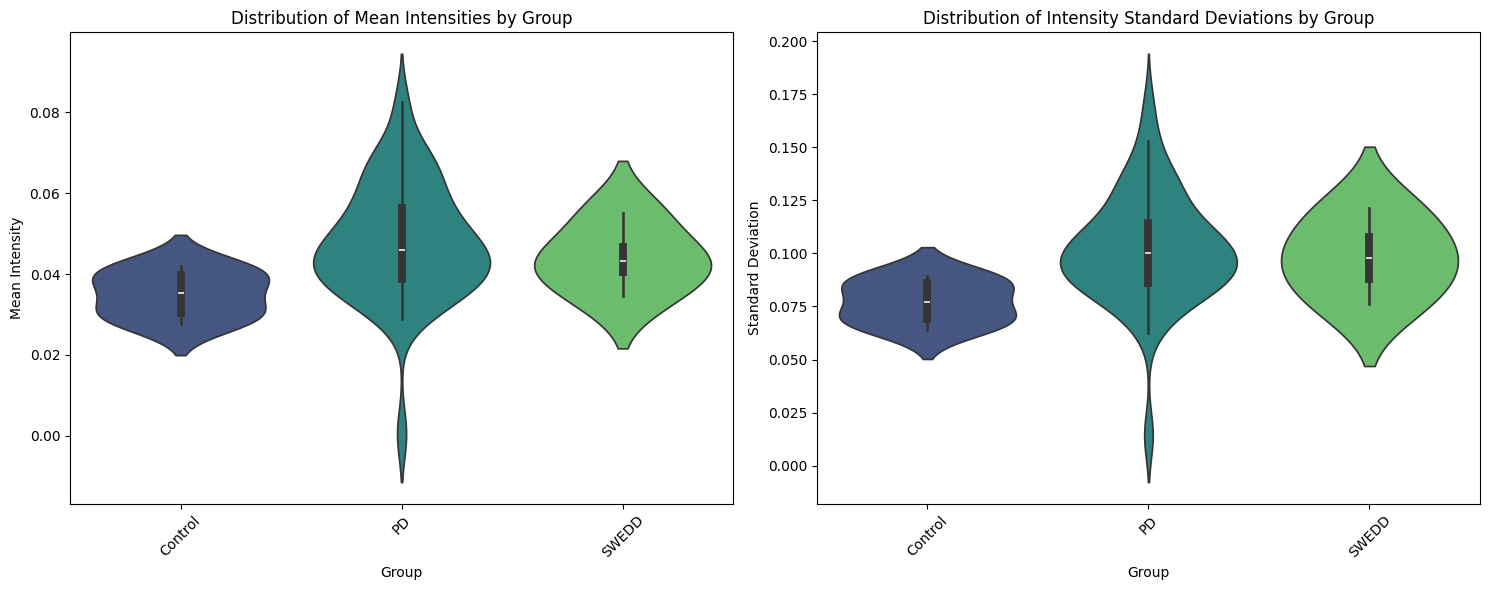


Plotting group statistics...


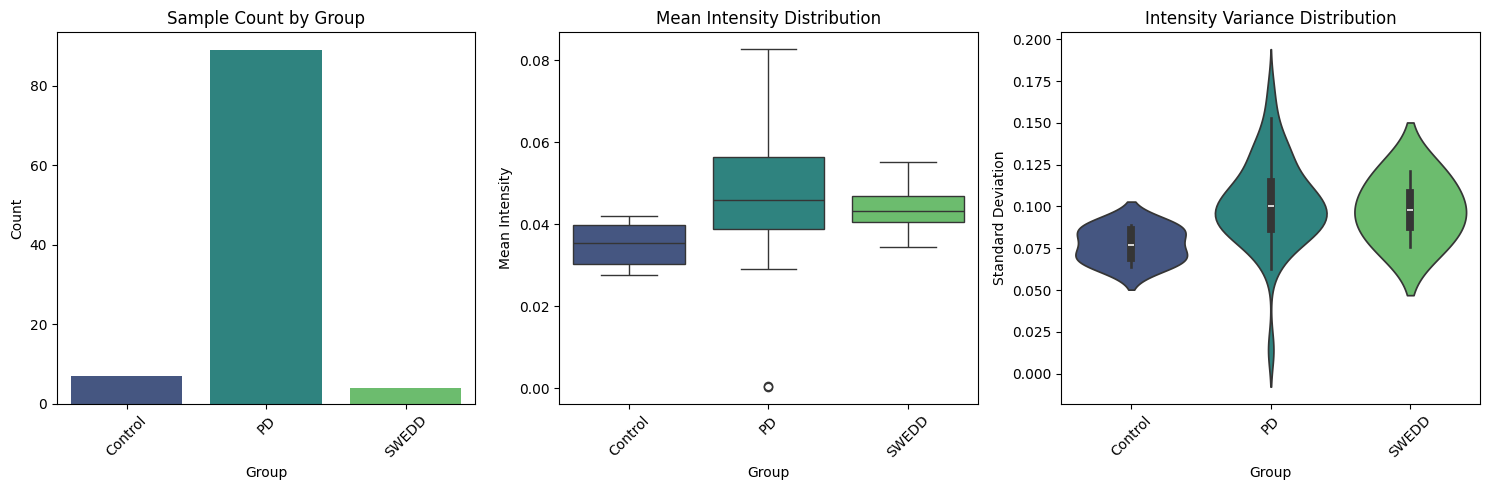


Analyzing spatial patterns...


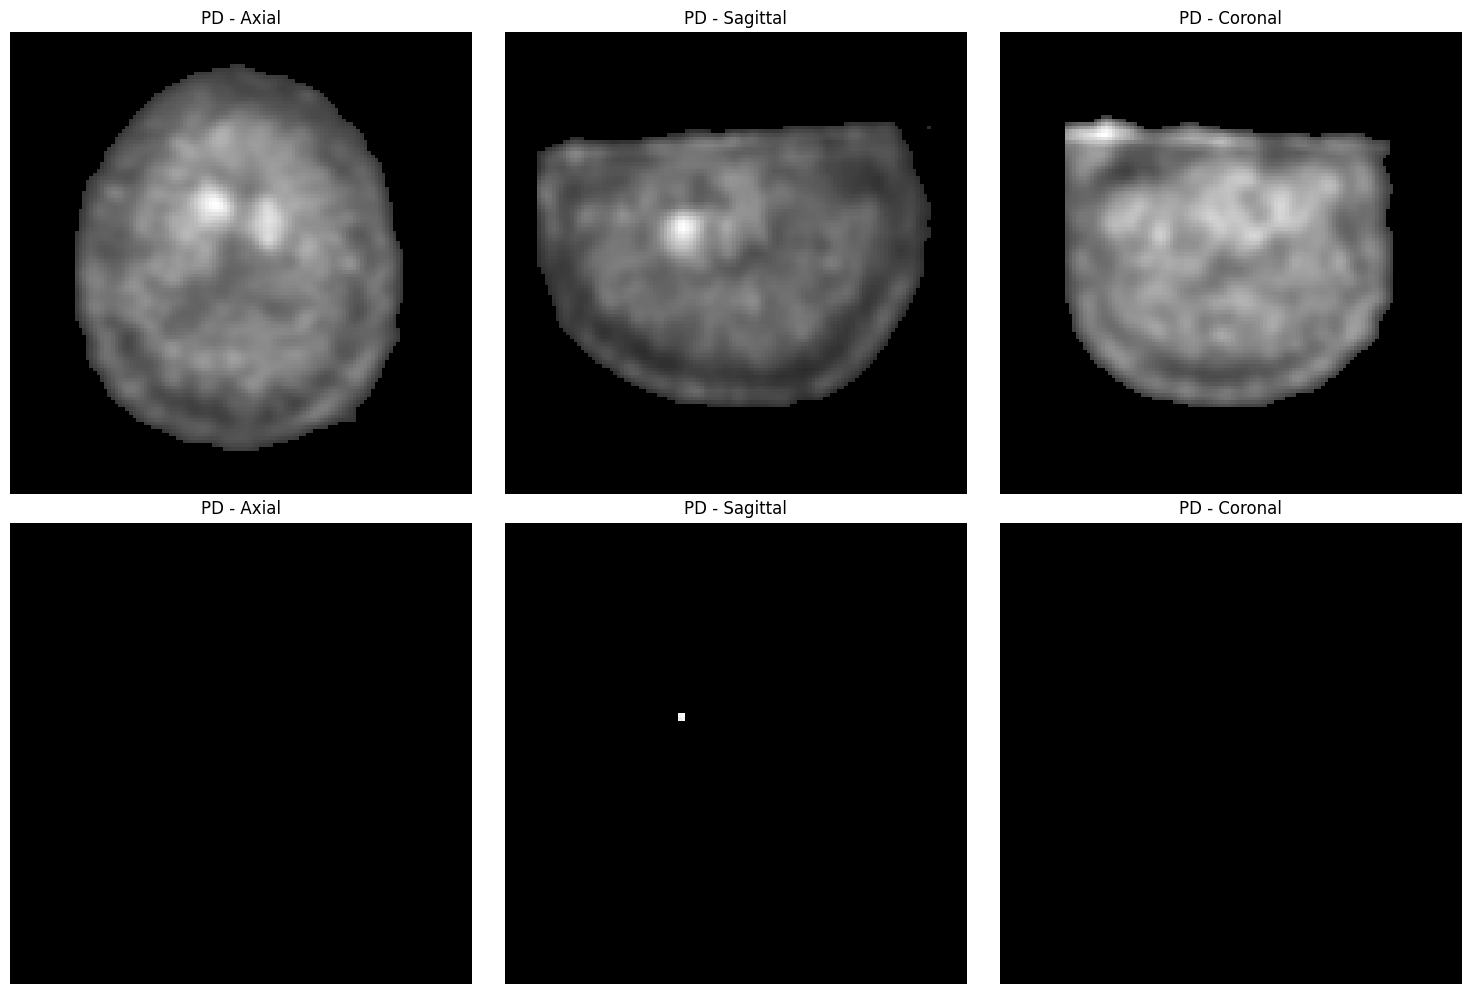


Summary Statistics by Group:
          mean           std        median       min       max     
          mean    std   mean    std   mean  std mean  std mean  std
label                                                              
Control  0.035  0.006  0.077  0.010    0.0  0.0  0.0  0.0  1.0  0.0
PD       0.048  0.015  0.102  0.026    0.0  0.0  0.0  0.0  1.0  0.0
SWEDD    0.044  0.008  0.098  0.019    0.0  0.0  0.0  0.0  1.0  0.0

EDA completed!


In [10]:
# Cell 10: Comprehensive EDA Implementation with Stratified Split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split

# First, let's implement proper stratified splitting
def create_stratified_dataloaders(df, batch_size=2, train_split=0.8):
    """
    Create train and validation dataloaders with stratified splitting to maintain class distributions
    """
    # Perform stratified split
    train_df, val_df = train_test_split(
        df, 
        test_size=1-train_split,
        stratify=df['label'],
        random_state=42
    )
    
    print("\nDataset split statistics:")
    print("Training set distribution:")
    print(train_df['label'].value_counts())
    print("\nValidation set distribution:")
    print(val_df['label'].value_counts())
    
    # Create datasets
    train_dataset = DaTScanDataset(train_df)
    val_dataset = DaTScanDataset(val_df)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    return train_loader, val_loader

def analyze_dataset_statistics(dataloader, num_batches=None):
    """
    Analyzes dataset statistics with memory-efficient batch processing
    Returns: Dictionary of statistical measures
    """
    print("Analyzing dataset statistics...")
    stats = defaultdict(list)
    
    try:
        for i, batch in enumerate(tqdm(dataloader, desc="Computing statistics")):
            if num_batches and i >= num_batches:
                break
                
            volumes = batch['volume']
            labels = batch['label']
            
            # Per-volume statistics
            for vol_idx, (volume, label) in enumerate(zip(volumes, labels)):
                vol_data = volume.numpy().flatten()
                
                stats['mean'].append(np.mean(vol_data))
                stats['std'].append(np.std(vol_data))
                stats['median'].append(np.median(vol_data))
                stats['min'].append(np.min(vol_data))
                stats['max'].append(np.max(vol_data))
                stats['label'].append(label)
                
            # Memory cleanup
            del volumes, labels
            gc.collect()
            torch.cuda.empty_cache()
            
    except Exception as e:
        print(f"Error during statistical analysis: {str(e)}")
        import traceback
        traceback.print_exc()
    
    return pd.DataFrame(stats)

def plot_intensity_distributions(stats_df):
    """
    Creates violin plots of intensity distributions by group
    """
    plt.figure(figsize=(15, 6))
    
    # Plot intensity distributions
    plt.subplot(1, 2, 1)
    sns.violinplot(data=stats_df, x='label', y='mean', palette='viridis')
    plt.title('Distribution of Mean Intensities by Group')
    plt.xlabel('Group')
    plt.ylabel('Mean Intensity')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    sns.violinplot(data=stats_df, x='label', y='std', palette='viridis')
    plt.title('Distribution of Intensity Standard Deviations by Group')
    plt.xlabel('Group')
    plt.ylabel('Standard Deviation')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_group_statistics(stats_df):
    """
    Plots statistical summaries by group
    """
    plt.figure(figsize=(15, 5))
    
    # Group counts
    plt.subplot(1, 3, 1)
    sns.countplot(data=stats_df, x='label', palette='viridis')
    plt.title('Sample Count by Group')
    plt.xlabel('Group')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Box plots
    plt.subplot(1, 3, 2)
    sns.boxplot(data=stats_df, x='label', y='mean', palette='viridis')
    plt.title('Mean Intensity Distribution')
    plt.xlabel('Group')
    plt.ylabel('Mean Intensity')
    plt.xticks(rotation=45)
    
    # Violin plots for variance
    plt.subplot(1, 3, 3)
    sns.violinplot(data=stats_df, x='label', y='std', palette='viridis')
    plt.title('Intensity Variance Distribution')
    plt.xlabel('Group')
    plt.ylabel('Standard Deviation')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def analyze_spatial_patterns(dataloader, num_samples_per_group=2):
    """
    Analyzes spatial patterns in the volumes, ensuring samples from each group
    """
    # Collect samples per group
    samples = defaultdict(list)
    
    print("Collecting samples for spatial analysis...")
    for batch in dataloader:
        volumes = batch['volume']
        labels = batch['label']
        
        for volume, label in zip(volumes, labels):
            if len(samples[label]) < num_samples_per_group:
                samples[label].append(volume)
        
        # Check if we have enough samples from each group
        if all(len(v) >= num_samples_per_group for v in samples.values()):
            break
    
    # Plot samples
    total_samples = len(samples) * num_samples_per_group
    plt.figure(figsize=(15, 5 * total_samples))
    
    plot_idx = 1
    for label in samples:
        for volume in samples[label]:
            # Get middle slices
            vol_data = volume.squeeze().numpy()
            axial = vol_data[vol_data.shape[0]//2, :, :]
            sagittal = vol_data[:, :, vol_data.shape[2]//2]
            coronal = vol_data[:, vol_data.shape[1]//2, :]
            
            # Plot
            plt.subplot(total_samples, 3, plot_idx)
            plt.imshow(axial, cmap='gray')
            plt.title(f'{label} - Axial')
            plt.axis('off')
            
            plt.subplot(total_samples, 3, plot_idx + 1)
            plt.imshow(sagittal, cmap='gray')
            plt.title(f'{label} - Sagittal')
            plt.axis('off')
            
            plt.subplot(total_samples, 3, plot_idx + 2)
            plt.imshow(coronal, cmap='gray')
            plt.title(f'{label} - Coronal')
            plt.axis('off')
            
            plot_idx += 3
    
    plt.tight_layout()
    plt.show()

# Create new stratified dataloaders
print("Creating stratified dataloaders...")
train_loader, val_loader = create_stratified_dataloaders(df, batch_size=2)

# Run the EDA
print("Starting Exploratory Data Analysis...")

# Analyze training dataset statistics
print("\nAnalyzing training dataset...")
train_stats = analyze_dataset_statistics(train_loader, num_batches=50)

# Plot distributions
print("\nPlotting intensity distributions...")
plot_intensity_distributions(train_stats)

# Plot group statistics
print("\nPlotting group statistics...")
plot_group_statistics(train_stats)

# Analyze spatial patterns
print("\nAnalyzing spatial patterns...")
analyze_spatial_patterns(train_loader, num_samples_per_group=2)

# Print summary statistics
print("\nSummary Statistics by Group:")
summary_stats = train_stats.groupby('label').agg({
    'mean': ['mean', 'std'],
    'std': ['mean', 'std'],
    'median': ['mean', 'std'],
    'min': ['mean', 'std'],
    'max': ['mean', 'std']
}).round(3)
print(summary_stats)

# Memory cleanup
gc.collect()
torch.cuda.empty_cache()
print("\nEDA completed!")

In [11]:
def analyze_slice_variance(dataloader, num_samples_per_group=5):
    """
    Analyzes slice-wise variance across different views for each patient group
    """
    print("Analyzing slice-wise variance patterns...")
    
    # Initialize storage for variances
    group_variances = {
        'PD': {'axial': [], 'coronal': [], 'sagittal': []},
        'Control': {'axial': [], 'coronal': [], 'sagittal': []},
        'SWEDD': {'axial': [], 'coronal': [], 'sagittal': []}
    }
    sample_counts = {'PD': 0, 'Control': 0, 'SWEDD': 0}
    
    try:
        for batch in tqdm(dataloader, desc="Computing slice variances"):
            volumes = batch['volume']
            labels = batch['label']
            
            for volume, label in zip(volumes, labels):
                label = label if isinstance(label, str) else label.item()
                
                if sample_counts[label] >= num_samples_per_group:
                    continue
                
                # Get volume data
                vol_data = volume.squeeze().numpy()
                d, h, w = vol_data.shape
                
                # Compute variance for each slice in each view
                axial_var = [np.var(vol_data[i, :, :]) for i in range(d)]
                coronal_var = [np.var(vol_data[:, i, :]) for i in range(h)]
                sagittal_var = [np.var(vol_data[:, :, i]) for i in range(w)]
                
                # Store variances
                group_variances[label]['axial'].append(axial_var)
                group_variances[label]['coronal'].append(coronal_var)
                group_variances[label]['sagittal'].append(sagittal_var)
                
                sample_counts[label] += 1
                
            # Check if we have enough samples from each group
            if all(count >= num_samples_per_group for count in sample_counts.values()):
                break
                
            # Memory cleanup
            del volumes, labels
            gc.collect()
            torch.cuda.empty_cache()
    
    except Exception as e:
        print(f"Error during variance analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None
    
    # Compute average variances across samples for each group
    avg_variances = {}
    for group in group_variances:
        avg_variances[group] = {
            view: np.mean(variances, axis=0) 
            for view, variances in group_variances[group].items()
        }
    
    return avg_variances

# Plot the slice variance results
def plot_slice_variances(avg_variances):
    """
    Creates line plots for slice-wise variance analysis
    """
    views = ['axial', 'coronal', 'sagittal']
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for idx, view in enumerate(views):
        ax = axes[idx]
        
        for group in avg_variances:
            variances = avg_variances[group][view]
            ax.plot(range(len(variances)), variances, label=group)
        
        ax.set_title(f'{view.capitalize()} View - Slice-wise Variance')
        ax.set_xlabel('Slice Index')
        ax.set_ylabel('Average Variance')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()



Analyzing slice-wise variance patterns...
Analyzing slice-wise variance patterns...


Computing slice variances:   0%|          | 0/1194 [00:00<?, ?it/s]


Plotting slice-wise variance analysis...


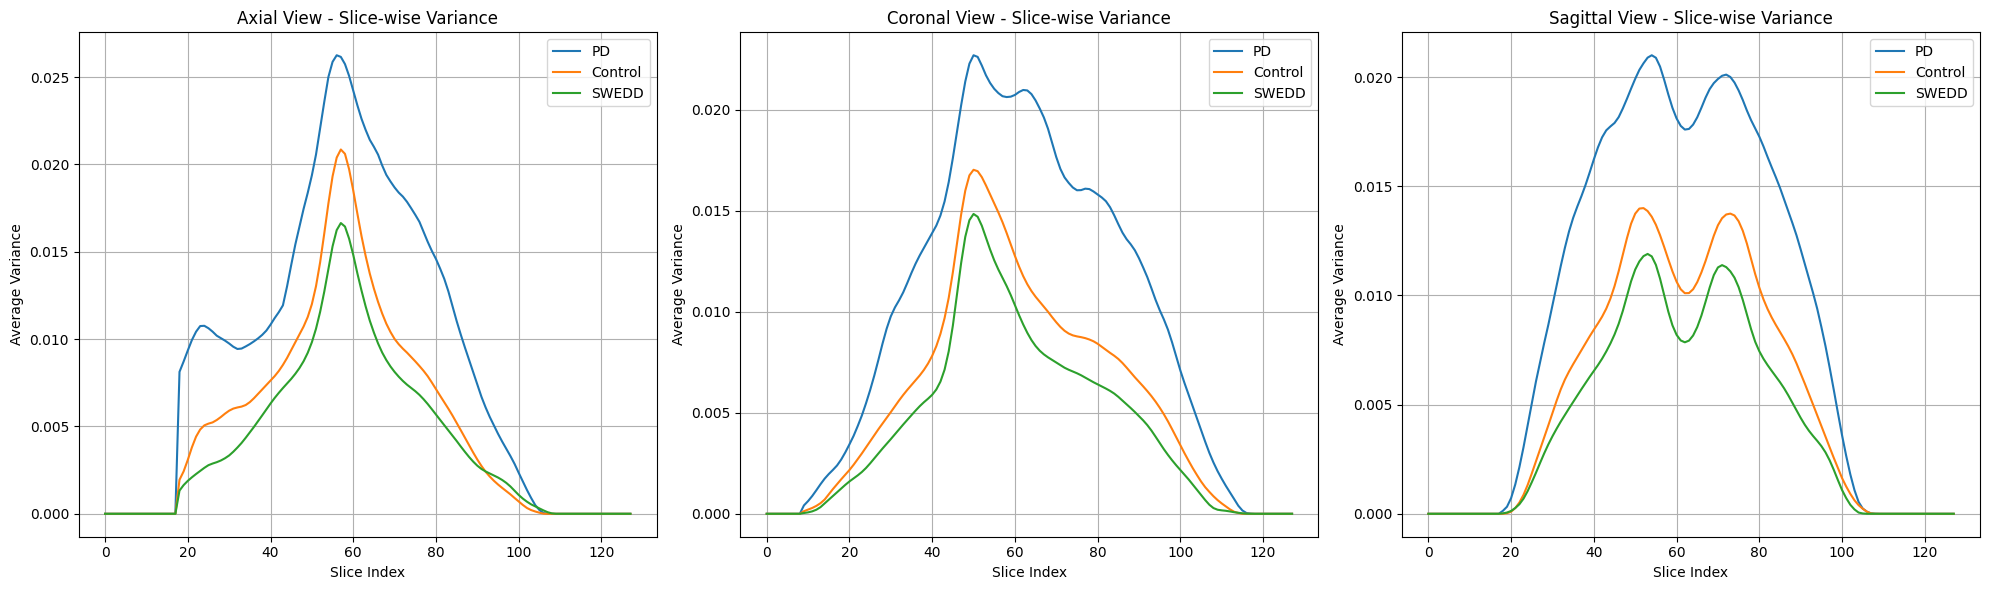

In [12]:
# Analyze slice-wise variance
print("\nAnalyzing slice-wise variance patterns...")
avg_variances = analyze_slice_variance(train_loader, num_samples_per_group=5)

if avg_variances is not None:
    print("\nPlotting slice-wise variance analysis...")
    plot_slice_variances(avg_variances)

# Model

## Autoencoder

In [10]:
# Cell 11: Base Autoencoder Implementation with Memory Optimization
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

import torch.cuda.amp as amp

class BaseAutoencoder(nn.Module):
    """Memory-optimized 3D Autoencoder with mixed precision support."""
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        # Enable CUDA benchmarking for optimal convolution algorithms
        torch.backends.cudnn.benchmark = True
        
    def forward(self, x):
        # Forward pass remains the same for compatibility
        z, skip_connections = self.encoder(x)
        reconstruction = self.decoder(z, skip_connections)
        return reconstruction

class ConvBlock(nn.Module):
    """Memory-efficient convolutional block with batch normalization and ReLU activation."""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            ('conv', nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)),
            ('bn', nn.BatchNorm3d(out_channels)),
            ('relu', nn.ReLU(inplace=True))  # inplace ReLU for memory efficiency
        ]))

    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    """3D Encoder network optimized for 128³ input volumes."""
    def __init__(self, latent_dim=256):
        super().__init__()
        
        # Initial feature extraction
        self.init_conv = ConvBlock(1, 16)  # 128 -> 128
        
        # Downsampling path with progressive channel increase
        self.down1 = nn.Sequential(
            ConvBlock(16, 32, stride=2),    # 128 -> 64
            ConvBlock(32, 32)
        )
        
        self.down2 = nn.Sequential(
            ConvBlock(32, 64, stride=2),    # 64 -> 32
            ConvBlock(64, 64)
        )
        
        self.down3 = nn.Sequential(
            ConvBlock(64, 128, stride=2),   # 32 -> 16
            ConvBlock(128, 128)
        )
        
        self.down4 = nn.Sequential(
            ConvBlock(128, 256, stride=2),  # 16 -> 8
            ConvBlock(256, 256)
        )
        
        # Project to latent space
        self.flatten_size = 256 * 8 * 8 * 8
        self.fc = nn.Linear(self.flatten_size, latent_dim)
        
    def forward(self, x):
        # Track shapes for debugging
        if self.training:
            print(f"Input shape: {x.shape}")
            
        x = self.init_conv(x)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        
        # Flatten and project to latent space
        flat = torch.flatten(d4, start_dim=1)
        z = self.fc(flat)
        
        if self.training:
            print(f"Latent shape: {z.shape}")
            
        return z, (d1, d2, d3, d4)

class Decoder(nn.Module):
    """3D Decoder network optimized for 128³ output volumes."""
    def __init__(self, latent_dim=256):
        super().__init__()
        
        self.flatten_size = 256 * 8 * 8 * 8
        self.fc = nn.Linear(latent_dim, self.flatten_size)
        
        # Upsampling path with skip connections
        self.up1 = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2),  # 8 -> 16
            ConvBlock(128, 128)
        )
        
        self.up2 = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2),   # 16 -> 32
            ConvBlock(64, 64)
        )
        
        self.up3 = nn.Sequential(
            nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2),    # 32 -> 64
            ConvBlock(32, 32)
        )
        
        self.up4 = nn.Sequential(
            nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2),    # 64 -> 128
            ConvBlock(16, 16)
        )
        
        # Final convolution
        self.final_conv = nn.Conv3d(16, 1, kernel_size=1)
        
    def forward(self, z, skip_connections):
        if self.training:
            print(f"Decoder input shape: {z.shape}")
            
        # Reshape from latent space
        x = self.fc(z)
        x = x.view(-1, 256, 8, 8, 8)
        
        # Unpack skip connections
        d1, d2, d3, d4 = skip_connections
        
        # Upsampling with skip connections
        x = self.up1(x + d4)
        x = self.up2(x + d3)
        x = self.up3(x + d2)
        x = self.up4(x + d1)
        
        # Final convolution with sigmoid activation
        x = torch.sigmoid(self.final_conv(x))
        
        if self.training:
            print(f"Output shape: {x.shape}")
            
        return x

class BaseAutoencoder(nn.Module):
    """Memory-optimized 3D Autoencoder for 128³ medical volumes."""
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def forward(self, x):
        z, skip_connections = self.encoder(x)
        reconstruction = self.decoder(z, skip_connections)
        return reconstruction
    
    def encode(self, x):
        """Encode input to latent space"""
        z, _ = self.encoder(x)
        return z
    
    def decode(self, z):
        """Decode from latent space (for generation)"""
        batch_size = z.size(0)
        device = z.device
        dummy_skips = (
            torch.zeros(batch_size, 32, 64, 64, 64, device=device),
            torch.zeros(batch_size, 64, 32, 32, 32, device=device),
            torch.zeros(batch_size, 128, 16, 16, 16, device=device),
            torch.zeros(batch_size, 256, 8, 8, 8, device=device)
        )
        return self.decoder(z, dummy_skips)

def test_autoencoder(batch_size=2):
    """Test the autoencoder with dummy data and verify memory usage."""
    print("\nTesting Autoencoder Architecture...")
    
    try:
        # Create model and move to GPU
        model = BaseAutoencoder()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        
        # Print model summary
        print("\nModel Architecture:")
        print(model)
        
        # Create dummy input (128³ volume)
        dummy_input = torch.randn(batch_size, 1, 128, 128, 128, device=device)
        
        # Print initial memory usage
        print("\nInitial GPU Memory Usage:")
        print_gpu_memory_stats()
        
        # Test forward pass
        print("\nTesting forward pass...")
        with torch.no_grad():
            output = model(dummy_input)
        
        # Print output shape and final memory usage
        print(f"\nOutput shape: {output.shape}")
        print("\nFinal GPU Memory Usage:")
        print_gpu_memory_stats()
        
        # Verify shapes
        assert output.shape == dummy_input.shape, f"Shape mismatch: {output.shape} vs {dummy_input.shape}"
        
        # Clean up
        del model, dummy_input, output
        torch.cuda.empty_cache()
        
        print("\nAutoencoder test completed successfully!")
        
    except Exception as e:
        print(f"Error testing autoencoder: {str(e)}")
        import traceback
        traceback.print_exc()

# Run test if this cell is executed
if __name__ == "__main__":
    test_autoencoder()


Testing Autoencoder Architecture...

Model Architecture:
BaseAutoencoder(
  (encoder): Encoder(
    (init_conv): ConvBlock(
      (block): Sequential(
        (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
    (down1): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
      )
      (1): ConvBlock(
        (block): Sequential(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
      )


In [11]:
# Cell 12: Training Utilities and Configuration
import os
import json
import time
from pathlib import Path
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

class TrainingConfig:
    """Training configuration optimized for NVIDIA 4070Ti"""
    def __init__(self, **kwargs):
        self.learning_rate = kwargs.get('learning_rate', 1e-4)
        self.batch_size = kwargs.get('batch_size', 8)  # Increased from 2 to 8
        self.accumulation_steps = kwargs.get('accumulation_steps', 4)  # New: gradient accumulation
        self.epochs = kwargs.get('epochs', 100)
        self.early_stopping_patience = kwargs.get('early_stopping_patience', 10)
        self.checkpoint_dir = kwargs.get('checkpoint_dir', 'checkpoints')
        self.model_name = kwargs.get('model_name', 'autoencoder')
        self.use_mixed_precision = kwargs.get('use_mixed_precision', True)  # Enable by default
        self.num_workers = kwargs.get('num_workers', 4)  # Optimize data loading
        self.pin_memory = kwargs.get('pin_memory', True)  # Faster data transfer to GPU

        # Create checkpoint directory
        Path(self.checkpoint_dir).mkdir(parents=True, exist_ok=True)

class EarlyStopping:
    """Early stopping handler with patience"""
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False
        
        if val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        
        return self.should_stop

class CheckpointHandler:
    """Handles saving and loading of model checkpoints"""
    def __init__(self, checkpoint_dir, model_name):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.model_name = model_name
        self.checkpoint_path = self.checkpoint_dir / f"{model_name}_checkpoint.pth"
        self.metadata_path = self.checkpoint_dir / f"{model_name}_metadata.json"
    
    def save(self, model, optimizer, scheduler, epoch, train_losses, val_losses):
        """Save model checkpoint and training metadata"""
        # Save model checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_losses': train_losses,
            'val_losses': val_losses
        }
        torch.save(checkpoint, self.checkpoint_path)
        
        # Save metadata
        metadata = {
            'last_epoch': epoch,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(self.metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)
    
    def load(self, model, optimizer, scheduler):
        """Load model checkpoint and return training metadata"""
        if not self.checkpoint_path.exists():
            return None
        
        checkpoint = torch.load(self.checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler and checkpoint['scheduler_state_dict']:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        return {
            'epoch': checkpoint['epoch'],
            'train_losses': checkpoint['train_losses'],
            'val_losses': checkpoint['val_losses']
        }

def print_gpu_memory_stats():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 2)
        reserved = torch.cuda.memory_reserved() / (1024 ** 2)
        print(f"GPU Memory Allocated: {allocated:.2f} MB")
        print(f"GPU Memory Reserved: {reserved:.2f} MB")

In [12]:
# Cell 13: Training Loop Implementation
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def train_autoencoder(model, train_loader, val_loader, config=None):
    """GPU-optimized training loop with mixed precision and gradient accumulation"""
    if config is None:
        config = TrainingConfig()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize training components
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    early_stopping = EarlyStopping(patience=config.early_stopping_patience)
    checkpoint_handler = CheckpointHandler(config.checkpoint_dir, config.model_name)

    # Mixed precision setup
    scaler = amp.GradScaler(enabled=config.use_mixed_precision)
    
    # Load checkpoint if available
    start_epoch = 0
    train_losses = []
    val_losses = []
    checkpoint_data = checkpoint_handler.load(model, optimizer, scheduler)
    if checkpoint_data:
        start_epoch = checkpoint_data['epoch'] + 1
        train_losses = checkpoint_data['train_losses']
        val_losses = checkpoint_data['val_losses']
        print(f"Resuming training from epoch {start_epoch}")

    try:
        for epoch in range(start_epoch, config.epochs):
            model.train()
            epoch_loss = 0
            optimizer.zero_grad()  # Zero gradients at epoch start
            
            train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.epochs} [Train]')
            
            for batch_idx, batch in enumerate(train_pbar):
                try:
                    volumes = batch['volume'].to(device, non_blocking=True)
                    
                    # Mixed precision forward pass
                    with amp.autocast(enabled=config.use_mixed_precision):
                        reconstructed = model(volumes)
                        loss = criterion(reconstructed, volumes)
                        # Scale loss by accumulation steps
                        loss = loss / config.accumulation_steps
                    
                    # Mixed precision backward pass
                    scaler.scale(loss).backward()
                    
                    # Gradient accumulation
                    if (batch_idx + 1) % config.accumulation_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                    
                    epoch_loss += loss.item() * config.accumulation_steps
                    train_pbar.set_postfix({'loss': loss.item() * config.accumulation_steps})
                    
                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"\nOOM in batch {batch_idx}. Adjusting batch size...")
                        torch.cuda.empty_cache()
                        continue
                    raise e
                
                # Clean up
                del volumes, reconstructed, loss
                torch.cuda.empty_cache()
            
            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Validation phase
            model.eval()
            val_loss = 0
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{config.epochs} [Val]')
            
            with torch.no_grad():
                for batch in val_pbar:
                    try:
                        volumes = batch['volume'].to(device)
                        reconstructed = model(volumes)
                        loss = criterion(reconstructed, volumes)
                        val_loss += loss.item()
                        
                    except RuntimeError as e:
                        if "out of memory" in str(e):
                            print("\nOOM during validation. Cleaning up...")
                            if 'volumes' in locals():
                                del volumes
                            if 'reconstructed' in locals():
                                del reconstructed
                            if 'loss' in locals():
                                del loss
                            torch.cuda.empty_cache()
                            continue
                        else:
                            raise e
                    
                    # Clean up
                    del volumes, reconstructed, loss
                    torch.cuda.empty_cache()
            
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            # Update learning rate
            scheduler.step(avg_val_loss)
            
            # Save checkpoint
            checkpoint_handler.save(
                model, optimizer, scheduler,
                epoch, train_losses, val_losses
            )
            
            # Print epoch summary
            print(f"\nEpoch {epoch+1}/{config.epochs}")
            print(f"Train Loss: {avg_train_loss:.6f}")
            print(f"Val Loss: {avg_val_loss:.6f}")
            print_gpu_memory_stats()
            
            # Early stopping check
            if early_stopping(avg_val_loss):
                print("\nEarly stopping triggered!")
                break
    
    except KeyboardInterrupt:
        print("\nTraining interrupted by user!")
    
    finally:
        # Plot training history
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(config.checkpoint_dir, f"{config.model_name}_training_history.png"))
        plt.show()
        
        return train_losses, val_losses

Resuming training from epoch 12


Epoch 13/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: to

Epoch 13/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 13/100
Train Loss: 0.002115
Val Loss: 0.001922
GPU Memory Allocated: 1417.02 MB
GPU Memory Reserved: 1804.00 MB


Epoch 14/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: to

Epoch 14/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 14/100
Train Loss: 0.001725
Val Loss: 0.001509
GPU Memory Allocated: 1417.02 MB
GPU Memory Reserved: 1804.00 MB


Epoch 15/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: to

Epoch 15/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 15/100
Train Loss: 0.001425
Val Loss: 0.001453
GPU Memory Allocated: 1417.02 MB
GPU Memory Reserved: 1804.00 MB


Epoch 16/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: to

Epoch 16/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 16/100
Train Loss: 0.001176
Val Loss: 0.001133
GPU Memory Allocated: 1417.02 MB
GPU Memory Reserved: 1804.00 MB


Epoch 17/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: to

Epoch 17/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 17/100
Train Loss: 0.000975
Val Loss: 0.001044
GPU Memory Allocated: 1417.02 MB
GPU Memory Reserved: 1804.00 MB


Epoch 18/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: to

Epoch 18/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 18/100
Train Loss: 0.000819
Val Loss: 0.000876
GPU Memory Allocated: 1417.02 MB
GPU Memory Reserved: 1804.00 MB


Epoch 19/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: to

Epoch 19/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 19/100
Train Loss: 0.000709
Val Loss: 0.000678
GPU Memory Allocated: 1417.02 MB
GPU Memory Reserved: 1804.00 MB


Epoch 20/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 128, 128, 128])
Input shape: torch.Size([2, 1, 128, 128, 128])
Latent shape: torch.Size([2, 256])
Decoder input shape: torch.Size([2, 256])
Output shape: to

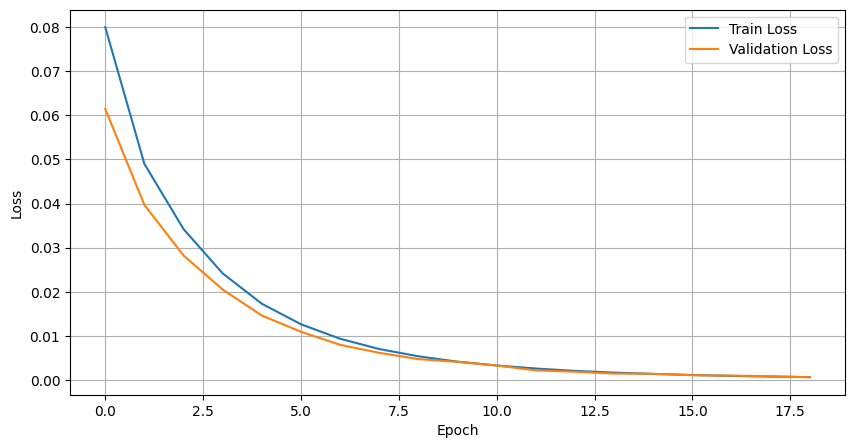

In [15]:
# TRAINING
if __name__ == "__main__":
    try:
        model = BaseAutoencoder()
        config = TrainingConfig(
            learning_rate=1e-4,
            batch_size=8,  # Increased batch size
            accumulation_steps=4,  # Gradient accumulation
            epochs=100,
            use_mixed_precision=True,
            num_workers=4,
            pin_memory=True
        )
        
        train_losses, val_losses = train_autoencoder(model, train_loader, val_loader, config)
    
    except Exception as e:
        print(f"Error during training: {str(e)}")
        import traceback
        traceback.print_exc()

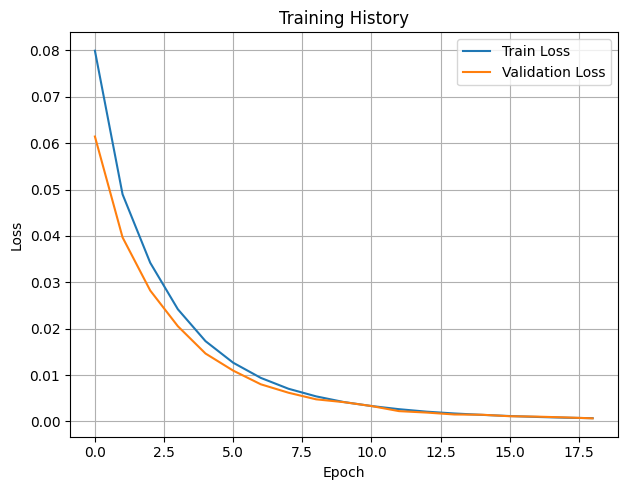

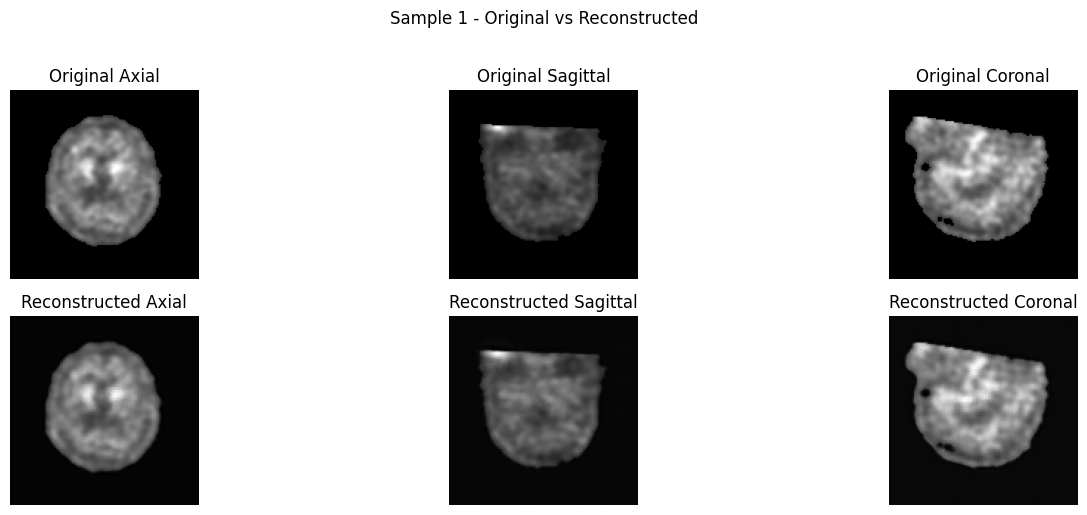

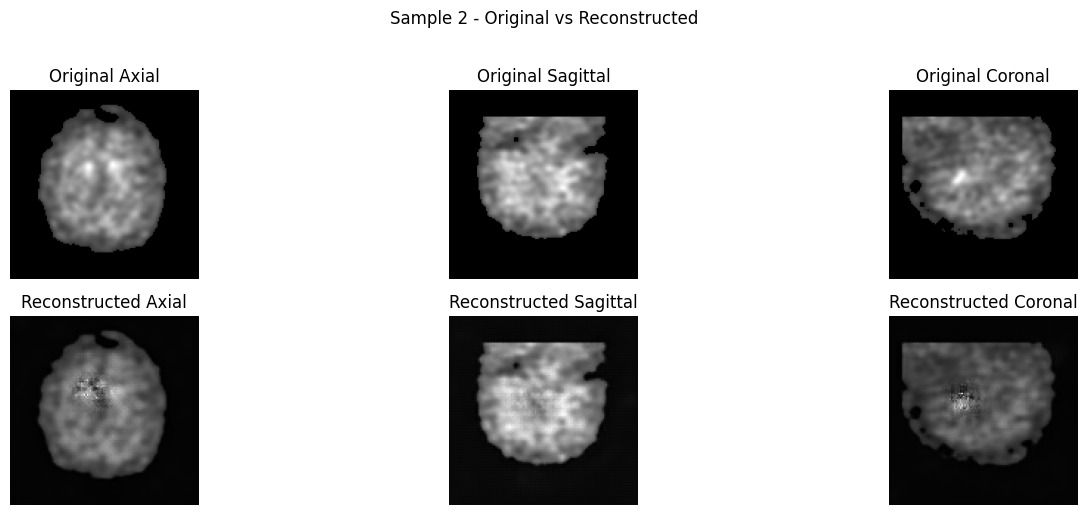

Computing metrics:   0%|          | 0/299 [00:00<?, ?it/s]

In [ ]:
# Cell 14: Model Evaluation and Visualization
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
from pathlib import Path

def load_checkpoint_for_evaluation(checkpoint_dir, model_name):
    """Load model and training history for evaluation"""
    checkpoint_path = Path(checkpoint_dir) / f"{model_name}_checkpoint.pth"
    metadata_path = Path(checkpoint_dir) / f"{model_name}_metadata.json"
    
    # Load model
    model = BaseAutoencoder()
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Load training history
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    return model, metadata

def plot_training_history(metadata):
    """Plot training and validation losses"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(metadata['train_losses'], label='Train Loss')
    plt.plot(metadata['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    
    # Plot recent epochs in detail
    recent_epochs = 20
    if len(metadata['train_losses']) > recent_epochs:
        plt.subplot(1, 2, 2)
        plt.plot(metadata['train_losses'][-recent_epochs:], label='Train Loss')
        plt.plot(metadata['val_losses'][-recent_epochs:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Last {recent_epochs} Epochs')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def visualize_reconstructions(model, val_loader, num_samples=3):
    """Visualize original vs reconstructed volumes"""
    device = next(model.parameters()).device
    
    with torch.no_grad():
        for batch in val_loader:
            volumes = batch['volume'].to(device)
            reconstructed = model(volumes)
            
            # Process num_samples samples
            for idx in range(min(num_samples, volumes.shape[0])):
                fig = plt.figure(figsize=(15, 5))
                
                # Get middle slices
                orig_vol = volumes[idx, 0].cpu().numpy()
                recon_vol = reconstructed[idx, 0].cpu().numpy()
                
                # Plot axial, sagittal, and coronal views
                views = ['Axial', 'Sagittal', 'Coronal']
                slices_orig = [
                    orig_vol[orig_vol.shape[0]//2, :, :],
                    orig_vol[:, orig_vol.shape[1]//2, :],
                    orig_vol[:, :, orig_vol.shape[2]//2]
                ]
                slices_recon = [
                    recon_vol[recon_vol.shape[0]//2, :, :],
                    recon_vol[:, recon_vol.shape[1]//2, :],
                    recon_vol[:, :, recon_vol.shape[2]//2]
                ]
                
                for i, (view, orig_slice, recon_slice) in enumerate(zip(views, slices_orig, slices_recon)):
                    # Original
                    plt.subplot(2, 3, i+1)
                    plt.imshow(orig_slice, cmap='gray')
                    plt.title(f'Original {view}')
                    plt.axis('off')
                    
                    # Reconstructed
                    plt.subplot(2, 3, i+4)
                    plt.imshow(recon_slice, cmap='gray')
                    plt.title(f'Reconstructed {view}')
                    plt.axis('off')
                
                plt.suptitle(f'Sample {idx+1} - Original vs Reconstructed', y=1.02)
                plt.tight_layout()
                plt.show()
            
            break  # Only process first batch

def compute_metrics(model, val_loader):
    """Compute quantitative metrics on validation set"""
    device = next(model.parameters()).device
    mse_criterion = nn.MSELoss()
    
    total_mse = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Computing metrics"):
            volumes = batch['volume'].to(device)
            reconstructed = model(volumes)
            
            mse = mse_criterion(reconstructed, volumes).item()
            total_mse += mse * volumes.shape[0]
            total_samples += volumes.shape[0]
    
    avg_mse = total_mse / total_samples
    print(f"\nValidation Metrics:")
    print(f"Average MSE: {avg_mse:.6f}")
    print(f"RMSE: {np.sqrt(avg_mse):.6f}")

# Example usage
if __name__ == "__main__":
    # Load latest checkpoint
    model, metadata = load_checkpoint_for_evaluation('checkpoints', 'autoencoder')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Plot training history
    plot_training_history(metadata)
    
    # Visualize reconstructions
    visualize_reconstructions(model, val_loader)
    
    # Compute metrics
    compute_metrics(model, val_loader)